In [51]:
# Classification with CNN
# Fashion MNist

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import seaborn as sns

In [52]:
f_mnist = tf.keras.datasets.fashion_mnist
(X_train, Y_train), (X_test, Y_test) = f_mnist.load_data()

print(X_train.shape)
print(X_test.shape)




(60000, 28, 28)
(10000, 28, 28)


In [53]:
# this is 2D array (but CNN needs 3D array)
# CNN needs height x and width x color
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print(X_train.shape)
print(X_test.shape)


(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [54]:
# k = len(np.unique(Y_train))
k = len(set(Y_train))
print("number of classes:", k)

print("shape: ",X_train[0].shape)

number of classes: 10
shape:  (28, 28, 1)


In [55]:
# Dataloaders
from torch.utils.data import DataLoader, TensorDataset
import torch

# Create TensorDatasets
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train).type(torch.LongTensor)) # Convert to PyTorch tensors and specify data type for labels
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(Y_test).type(torch.LongTensor))   # Convert to PyTorch tensors and specify data type for labels

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)  # Use train_data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False) # Use test_data


In [56]:
import torch.nn as nn
import torch.nn.functional as F

class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Input layer (flattened image)
        self.fc2 = nn.Linear(128, 64)      # Hidden layer
        self.fc3 = nn.Linear(64, 10)       # Output layer (10 classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)            # No activation (logits for classification)
        return x

model = FashionMNISTModel()
print(model)


FashionMNISTModel(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [57]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer


In [58]:
# Device (GPU or CPU)
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()       # Clear gradients
        outputs = model(images)     # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()             # Backward pass
        optimizer.step()            # Update weights

        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')


Epoch [1/5], Loss: 608.1901
Epoch [2/5], Loss: 402.9778
Epoch [3/5], Loss: 367.3956
Epoch [4/5], Loss: 346.6982
Epoch [5/5], Loss: 332.7084


In [62]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')




Test Accuracy: 85.55%


In [63]:

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[875   8  18  16   5   2  64   1  11   0]
 [  4 968   2  20   3   0   1   0   1   1]
 [ 20   0 770   9 165   0  35   0   1   0]
 [ 72  20  14 807  66   2  16   0   1   2]
 [  0   0  84  15 851   0  50   0   0   0]
 [  0   0   0   0   0 925   0  49   0  26]
 [235   4 122  24  84   0 511   1  19   0]
 [  0   0   0   0   0   6   0 934   0  60]
 [  4   0   6   4   6  17   3   9 950   1]
 [  0   0   0   0   0   7   0  28   1 964]]


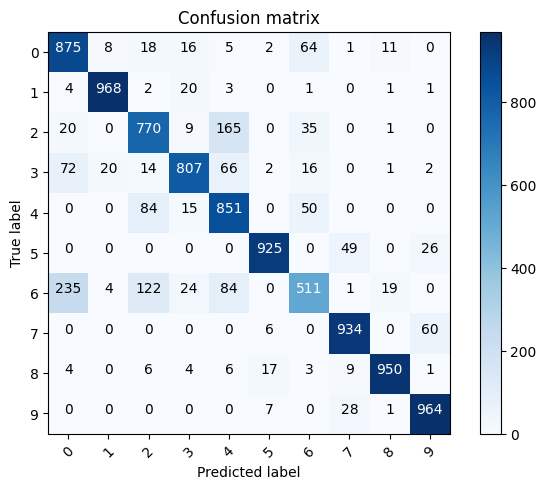

In [64]:
#predict
from sklearn.metrics import confusion_matrix

with torch.no_grad():  # Disable gradient calculation during inference
    # Move data to the appropriate device
    X_test_tensor = torch.Tensor(X_test).to(device)
    # Reshape the input to match the model's expected input shape
    X_test_tensor = X_test_tensor.view(X_test_tensor.size(0), -1)
    # Make predictions using the model's forward method
    p_test = model(X_test_tensor).argmax(axis=1).cpu().numpy()

cm = confusion_matrix(Y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))


misclassified examples count:  1445


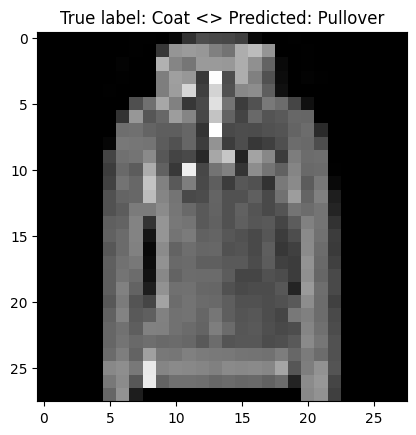

In [103]:
# plot the traiming loss vs test loss
# show some misclassified example
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

misclassified_idx = np.where(p_test != Y_test)[0]
print("misclassified examples count: ", len(misclassified_idx))

i = np.random.choice(misclassified_idx)
plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
plt.title("True label: %s <> Predicted: %s" % (class_labels[Y_test[i]], class_labels[p_test[i]]));



In [98]:
import os
import numpy as np
from PIL import Image

from google.colab import files
uploaded = files.upload()

Saving shirt.jpg to shirt.jpg


In [99]:

from PIL import Image
import numpy as np

# Load the JPEG image
image = Image.open('shirt.jpg')

#1
image = image.convert('L')  # Convert to grayscale
image = image.resize((28, 28)) # Resize the image to 28x28 pixels
#end--------

image_array = np.array(image) # Convert the image to a numpy array
image_array = image_array.reshape(1, 28, 28, 1)

# Ensure the array is of type uint8
image_array = image_array.astype(np.uint8)

image_array # original shape (148, 148, 3)

X_train[0].shape, image_array.shape



((28, 28, 1), (1, 28, 28, 1))

Predicted class: Bag


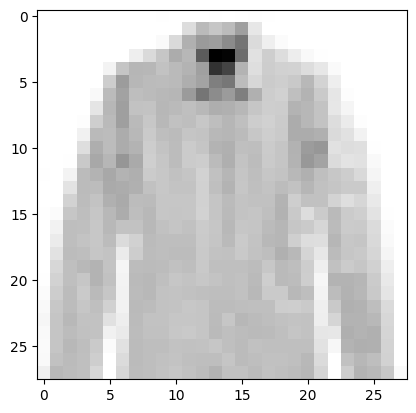

In [100]:
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Make predictions
with torch.no_grad():  # Disable gradient calculation during inference
    # Move data to the appropriate device
    image_array_tensor = torch.Tensor(image_array).to(device)
    # Reshape the input if necessary to match the model's expected input shape
    # Example: image_array_tensor = image_array_tensor.view(image_array_tensor.size(0), -1)
    # Make predictions using the model's forward method
    predictions = model(image_array_tensor)

predicted_class = np.argmax(predictions.cpu().detach().numpy()[0]) # Get the predicted class index
print(f'Predicted class: {class_labels[predicted_class]}')

plt.imshow(image, cmap='gray')
